In [1]:
# Uncomment if running code on Colab
!pip install datasets
!pip install torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import necesssary modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchtext.vocab as vocab

import pandas as pd
import numpy as np
from datasets import load_dataset
from tqdm import tqdm
from collections import Counter
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

# Set device = CUDA if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

Device:  cuda


In [3]:
# Download the dataset using HuggingFace load_dataset
ptb = load_dataset('ptb_text_only')

  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# View Dataset Splits
print('Dataset Split:', ptb)

# Train Data
train_data = ptb['train']['sentence']
# Val Data
val_data = ptb['validation']['sentence']
# Test Data
test_data = ptb['test']['sentence']

Dataset Split: DatasetDict({
    train: Dataset({
        features: ['sentence'],
        num_rows: 42068
    })
    test: Dataset({
        features: ['sentence'],
        num_rows: 3761
    })
    validation: Dataset({
        features: ['sentence'],
        num_rows: 3370
    })
})


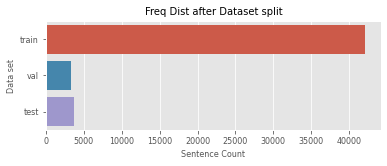

In [5]:
# Dataset Split Plot
ds_list = ['train', 'val', 'test']
sent_count_list = [ptb['train'].num_rows, ptb['validation'].num_rows, ptb['test'].num_rows]

def plot_ds_split(ds_list, 
                  sent_count_list, 
                  xlabel, 
                  ylabel, 
                  title, 
                  filepath):
    dist_df = pd.DataFrame({'sent_count_list': sent_count_list, 'ds_list': ds_list})
    plt.style.use('ggplot')
    plt.figure(figsize = (6, 2))
    sns.barplot(x = 'sent_count_list', y = 'ds_list' , data = dist_df, orient = 'h')
    plt.xlabel(xlabel, size = 8)
    plt.ylabel(ylabel, size = 8)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.title(title, size = 10)
    # Comment if running on Colab
    # plt.savefig(filepath)
    
plot_ds_split(ds_list, sent_count_list, 'Sentence Count', 'Data set', 'Freq Dist after Dataset split', 'Images/dataset_split.png')

In [6]:
# Tokenize
def tokenize(text):
    return [i for i in text.split()]

# Load Words
def load_words(data):
    tokenized_sent = list()
    for sentence in tqdm(data, desc = 'List of Tokens', colour = 'red'):
        tokenized_sent.append(tokenize('<start> ' + sentence))
    return sum(tokenized_sent, [])

In [7]:
# List of Tokenized Words in the Train Corpus
words = load_words(train_data)

# Vocab: List of Unique Words
vocab = Counter(words)

# Print Vocab Length
VOCAB_LEN = len(vocab)
print('Vocab Length: ', VOCAB_LEN)

List of Tokens: 100%|██████████| 42068/42068 [00:00<00:00, 160317.41it/s]


Vocab Length:  10000


In [8]:
# Word-to-Index Dictionary for Vocab
word2idx = { term: idx for idx, term in enumerate(vocab) }

# Index-to-Word Dictionary for Vocab
idx2word = { idx: word for word,idx in word2idx.items() }

In [9]:
# Load GloVe Embeddings
import torchtext.vocab as vocab
GLOVE_DIM = 300
glove = vocab.GloVe(name = '840B', dim = GLOVE_DIM)

print('Loaded {} words present in GloVe'.format(len(glove.itos)))

# Get Embedding for given word
def get_word_embedding(word):
    return glove.vectors[glove.stoi[word]]

.vector_cache/glove.840B.300d.zip: 2.18GB [06:50, 5.31MB/s]                            
100%|█████████▉| 2196016/2196017 [03:11<00:00, 11493.47it/s]


Loaded 2196017 words present in GloVe


In [10]:
start_tensor = torch.zeros(1, GLOVE_DIM, device = device) # Word Embedding Tensor for <start>
unk_tensor = torch.rand(1, GLOVE_DIM, device = device) # Word Embedding Tensor for <unk>

# Create Embedding Matrix for Vocab
embeddings = []
for word in word2idx:
    if word in glove.stoi: # If word present in GloVe
        embeddings.append(get_word_embedding(word)) 
    else:
        if(word == '<start>'): # If word is <start>
            embeddings.append(start_tensor) 
        else: # If word is <unk> or not present in GloVe
            embeddings.append(unk_tensor)
            
temp_list = []
for emb in embeddings:
    temp_list.append(emb.detach().cpu().numpy().squeeze().tolist())
# Tensor of Word Embeddings for each word in vocab
embeddings_tensor = torch.tensor(temp_list, device = device)

In [11]:
# LangModel Class for DataLoader
class LangModelDataset(Dataset):
    
    # Constructor
    def __init__(self, 
                 data: list):
        self.data = data
        # Default Sequence Length
        self.sequence_length = 30
        self.words = self.load_words()
         # Create List of tokens in the Corpus
        self.token_list = list()
        for word in self.words:
            if word in word2idx: 
                self.token_list.append(word2idx[word])
            else:
                self.token_list.append(1)
    
    # Length of Number of Sequences for a Dataset split
    def __len__(self):
        return len(self.token_list) - self.sequence_length
    
    # List of Tokenized Words in the Corpus
    def load_words(self):
        tokenized_sent = list()
        for sentence in self.data:
            tokenized_sent.append(self.tokenize('<start> ' + sentence))
        return sum(tokenized_sent, [])
    
    def __getitem__(self, 
                    idx: int):
        # Input Sequence Tensor
        x = torch.tensor(self.token_list[idx : idx + self.sequence_length], device = device)
        # Target Sequence Tensor
        y = torch.tensor(self.token_list[idx + 1 : idx + self.sequence_length + 1], device = device)
        return x, y
        
    # Tokenize a sentence using split()  
    def tokenize(self, 
                 text: str):
        return [i for i in text.split()]

In [12]:
# Language Model Object for DataLoader
# Train Dataset Object
train_ds = LangModelDataset(train_data)

# Val Dataset Object
val_ds = LangModelDataset(val_data)

# Test Dataset Object
test_ds = LangModelDataset(test_data)

In [13]:
# Model Hyper-Parameters
BATCH_SIZE = 64
EMBEDDING_DIM = GLOVE_DIM
HIDDEN_DIM = 128
OUTPUT_DIM = VOCAB_LEN
NUM_LAYERS = 2
BIDIRECTION = False
DROPOUT = 0.2
LEARNING_RATE = 0.01

In [14]:
# Pytorch Data Loaders
# Train Data Loader
train_loader = DataLoader(train_ds, 
                          batch_size = BATCH_SIZE, 
                          shuffle = True)
# Val Data Loader
val_loader = DataLoader(val_ds, 
                        batch_size = BATCH_SIZE, 
                        shuffle = True)
# Test Data Loader
test_loader = DataLoader(test_ds, 
                        batch_size = 1, 
                        shuffle = False)

In [15]:
# RNN / LSTM / GRU Model
class LSTM(nn.Module):
    
    # Constructor
    def __init__(self, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout):
        super().__init__()
        # Initialize Embedding Layer with Pre-Trained GloVe Embeddings
        self.embedding = nn.Embedding.from_pretrained(embeddings_tensor)
        # Initialize LSTM layer to process the vector sequences 
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True)
        num_directions = 2 if bidirectional else 1
        # Initialize Dense layers to predict
        self.fc1 = nn.Linear(hidden_dim * num_directions, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # Initialize dropout to improve with regularization
        self.dropout = nn.Dropout(dropout)
        
    # Forward Pass of Model    
    def forward(self, 
                x):
        # Embedding Layer
        embedded = self.embedding(x)
        # Dropout Layer before Seq Layer
        embedded = self.dropout(embedded)
         # LSTM Layer
        output, (hidden, cell) = self.lstm(embedded)
        # 1st Fully Connected Layer
        output = self.fc1(output)
        # Dropout Layer before Output
        output = self.dropout(output)
        # 2nd Fully Connected Layer
        output = self.fc2(output)
        return output

In [16]:
# Set Seed Value to make results reproducible
torch.manual_seed(32)

model = LSTM(EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            NUM_LAYERS, 
            BIDIRECTION, 
            DROPOUT).to(device)

print('LSTM Model: ', model)

LSTM Model:  LSTM(
  (embedding): Embedding(10000, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10000, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [17]:
# Model Train Function
def train(loader, 
          model, 
          optimizer, 
          loss_fn):
    # Set model to train mode
    model.train()
    losses = []
    pbar = tqdm(loader, desc = 'Training Loop', colour = 'green')
    for x, y in pbar:
        optimizer.zero_grad()
        
        # Calculate y_pred
        y_pred = model(x) # [Batch_Length, Sequence Length, Output Dim]
        
        # Convert y_pred to 2D Tensor
        y_pred = y_pred.view(-1, y_pred.shape[-1]) # [Batch_Length * Sequence Length, Output Dim]
        # Convert y to 1D Tensor
        y = torch.flatten(y) # [Batch_Length * Sequence Length]
        
        # Loss
        loss = loss_fn(y_pred, y)
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())
        
        # Calculate gradients for w/b
        loss.backward()  
        # Update weights according to optimizer rules
        optimizer.step()
    return round((sum(losses) / len(losses)), 4) # Return Average Loss

# Model Evaluate Function
def evaluate(loader, 
             model, 
             loss_fn):
    # Set model to eval mode
    model.eval()
    losses = []
    pbar = tqdm(loader, desc = 'Evaluation Loop', colour = 'cyan')
    for x, y in pbar:
        # Calculate y_pred
        y_pred = model(x) # [Batch_Length, Sequence Length, Output Dim]
              
        # Convert y_pred to 2D Tensor
        y_pred = y_pred.view(-1, y_pred.shape[-1]) # [Batch_Length * Sequence Length, Output Dim]
        # Convert y to 1D Tensor
        y = torch.flatten(y) # [Batch_Length * Sequence Length]
        
        # Loss
        loss = loss_fn(y_pred, y)
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())
    
    return round((sum(losses) / len(losses)), 4) # Return Average Loss

In [18]:
# Model Training on Train dataset and Evaluation on Validation dataset

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = LEARNING_RATE)

# Loss Function -> Cross-Entropy Loss
loss_fn = nn.CrossEntropyLoss().to(device)

train_loss_list = []
train_ppl_list = []
val_loss_list = []
val_ppl_list = []

# Number of Epochs to run
n_epochs = 10

# Path to Save Best Model
PATH = f'best-model.pt'

for epoch in range(n_epochs):
    # Avg Training Loss
    train_loss = train(train_loader, 
                       model, 
                       optimizer, 
                       loss_fn)
    train_loss_list.append(train_loss)
    # Train Perplexity
    train_ppl = torch.exp(torch.tensor(train_loss, device = device))
    train_ppl_list.append(train_ppl.detach().cpu().numpy())
    
    # Avg Val Loss
    val_loss = evaluate(val_loader, 
                        model, 
                        loss_fn)
    val_loss_list.append(val_loss)
    # Val Perplexity
    val_ppl = torch.exp(torch.tensor(val_loss, device = device))
    val_ppl_list.append(val_ppl.detach().cpu().numpy())
    
    print("Epoch {0} --> Train Loss: {1} | Train PPL: {2} | Val Loss: {3} | Val PPL: {4}".format(epoch + 1, train_loss, train_ppl, val_loss, val_ppl))
    
    # Save model
    torch.save(model.state_dict(), PATH)

Evaluation Loop: 100%|██████████| 1153/1153 [00:12<00:00, 93.59it/s, Loss=4.27]


Epoch 1 --> Train Loss: 4.732 | Train PPL: 113.52236938476562 | Val Loss: 4.8068 | Val PPL: 122.33949279785156


Evaluation Loop: 100%|██████████| 1153/1153 [00:12<00:00, 92.81it/s, Loss=3.84]


Epoch 2 --> Train Loss: 4.5044 | Train PPL: 90.4140625 | Val Loss: 4.7734 | Val PPL: 118.3208236694336


Evaluation Loop: 100%|██████████| 1153/1153 [00:12<00:00, 92.53it/s, Loss=4.33]


Epoch 3 --> Train Loss: 4.4679 | Train PPL: 87.17345428466797 | Val Loss: 4.7711 | Val PPL: 118.04903411865234


Evaluation Loop: 100%|██████████| 1153/1153 [00:12<00:00, 89.24it/s, Loss=5.52]


Epoch 4 --> Train Loss: 4.4504 | Train PPL: 85.66118621826172 | Val Loss: 4.7874 | Val PPL: 119.98896789550781


Evaluation Loop: 100%|██████████| 1153/1153 [00:12<00:00, 92.99it/s, Loss=4.91]


Epoch 5 --> Train Loss: 4.4395 | Train PPL: 84.73255157470703 | Val Loss: 4.7593 | Val PPL: 116.66426086425781


Evaluation Loop: 100%|██████████| 1153/1153 [00:12<00:00, 91.83it/s, Loss=4.26]


Epoch 6 --> Train Loss: 4.4316 | Train PPL: 84.0658187866211 | Val Loss: 4.7589 | Val PPL: 116.61760711669922


Evaluation Loop: 100%|██████████| 1153/1153 [00:12<00:00, 92.86it/s, Loss=5.58]


Epoch 7 --> Train Loss: 4.4268 | Train PPL: 83.66324615478516 | Val Loss: 4.7535 | Val PPL: 115.98954010009766


Evaluation Loop: 100%|██████████| 1153/1153 [00:12<00:00, 93.23it/s, Loss=4.92]


Epoch 8 --> Train Loss: 4.4222 | Train PPL: 83.27931213378906 | Val Loss: 4.7642 | Val PPL: 117.23731994628906


Evaluation Loop: 100%|██████████| 1153/1153 [00:12<00:00, 92.92it/s, Loss=4.79]


Epoch 9 --> Train Loss: 4.4184 | Train PPL: 82.96342468261719 | Val Loss: 4.7652 | Val PPL: 117.35459899902344


Evaluation Loop: 100%|██████████| 1153/1153 [00:12<00:00, 92.67it/s, Loss=4.56]


Epoch 10 --> Train Loss: 4.4159 | Train PPL: 82.75630950927734 | Val Loss: 4.758 | Val PPL: 116.51265716552734


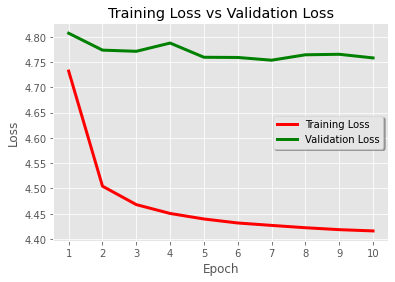

In [21]:
# Line Plot Comparison
epochs = np.arange(n_epochs) + 1

def plot_line(line_A_vals, 
              line_B_vals, 
              line_A_label, 
              line_B_label, 
              xlabel, 
              ylabel, 
              title, 
              filepath):
    plt.style.use('ggplot')
    plt.plot(epochs, line_A_vals, label = line_A_label, color = "red", linewidth = '3', )
    plt.plot(epochs, line_B_vals, label = line_B_label, color = "green", linewidth = '3')
    plt.xlabel(xlabel)
    plt.xticks(epochs)
    plt.ylabel(ylabel)
    plt.title(title, color = 'black')
    plt.legend(shadow = True)
    # Comment if running on Colab
    # plt.savefig(filepath)
    
# Training vs Validation Loss Plot
plot_line(train_loss_list, 
          val_loss_list, 
          'Training Loss', 
          'Validation Loss', 
          'Epoch', 
          'Loss', 
          'Training Loss vs Validation Loss', 
          'Images/train_vs_val_loss_plot.png')

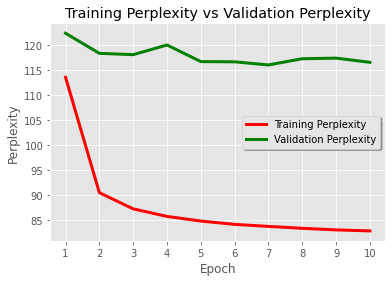

In [22]:
# Training vs Validation Perplexity Plot
plot_line(train_ppl_list, 
          val_ppl_list, 
          'Training Perplexity', 
          'Validation Perplexity', 
          'Epoch', 
          'Perplexity', 
          'Training Perplexity vs Validation Perplexity', 
          'Images/train_vs_val_ppl_plot.png')

In [23]:
# Load the saved model
saved_model = LSTM(EMBEDDING_DIM, 
                   HIDDEN_DIM, 
                   OUTPUT_DIM, 
                   NUM_LAYERS, 
                   BIDIRECTION, 
                   DROPOUT).to(device)

saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()

LSTM(
  (embedding): Embedding(10000, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10000, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [24]:
# Model Test Function
def test(loader, 
         model, 
         loss_fn):
    # Set model to eval mode
    model.eval()
    losses = []
    pbar = tqdm(loader, desc = 'Test Loop', colour = 'yellow')
    for x, y in pbar:
        with torch.no_grad():
            # Calculate y_pred
            y_pred = model.forward(x) # [Batch_Length, Sequence Length, Output Dim]

            # Convert y_pred to 2D Tensor
            y_pred = y_pred.view(-1, y_pred.shape[-1]) # [Batch_Length * Sequence Length, Output Dim]
            # Convert y to 1D Tensor
            y = torch.flatten(y) # [Batch_Length * Sequence Length]
            
            # Loss
            loss = loss_fn(y_pred, y)
            pbar.set_postfix({'Loss': loss.item()})
            losses.append(loss.item())
    
    return round((sum(losses) / len(losses)), 4) # Return Average Loss

# Avg Test Loss
test_loss = test(test_loader, 
                 saved_model, 
                 loss_fn)
# Test Perplexity
test_ppl = torch.exp(torch.tensor(test_loss, device = device))

print("Test Loss: {0} | Test PPL: {1}".format(test_loss, test_ppl))

Test Loop: 100%|██████████| 82400/82400 [06:17<00:00, 218.42it/s, Loss=4.92]


Test Loss: 4.6888 | Test PPL: 108.72261810302734
